Importing libraires

In [11]:
import os
import yaml
import torch
from ultralytics import YOLO
from pathlib import Path
import re
import matplotlib.pyplot as plt
from torchvision.ops import box_iou
import torch.nn as nn
import torch.nn.functional as F

### PRESETTING

In [13]:
#setting the pathes and the yaml file
images_dir = '/content/drive/MyDrive/data_(1)/augmented_train/images'
labels_dir = '/content/drive/MyDrive/data_(1)/augmented_train/labels'
data_yaml_path = 'climbing_data.yaml'
output_dir = '/content/drive/MyDrive/climbing_holds_model'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


print(f"Images directory exists: {os.path.exists(images_dir)}")
print(f"Labels directory exists: {os.path.exists(labels_dir)}")

Images directory exists: True
Labels directory exists: True


In [14]:
# Create YOLO data configuration
dataset_info = {
    'train': images_dir,
    'val': images_dir,
    'nc': 1,
    'names': ['climbing_hold']
}

with open(data_yaml_path, 'w') as file:
    yaml.dump(dataset_info, file)

### CUSTOM LOSS FUNCTION

In [15]:
class GripLoss(nn.Module):
    def __init__(self, lambda_cls=0.5, lambda_loc=2.5, lambda_obj=1.0, gamma=2.0):
        super(GripLoss, self).__init__()
        self.lambda_cls = lambda_cls
        self.lambda_loc = lambda_loc
        self.lambda_obj = lambda_obj
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def focal_loss(self, pred, target, alpha=0.25):
        bce_loss = self.bce(pred, target)
        pt = torch.exp(-bce_loss)
        focal = alpha * (1 - pt) ** self.gamma * bce_loss
        return focal.mean()

    def ciou_loss(self, pred_boxes, target_boxes):
        eps = 1e-7
        x1 = torch.max(pred_boxes[..., 0], target_boxes[..., 0])
        y1 = torch.max(pred_boxes[..., 1], target_boxes[..., 1])
        x2 = torch.min(pred_boxes[..., 2], target_boxes[..., 2])
        y2 = torch.min(pred_boxes[..., 3], target_boxes[..., 3])

        inter = (x2 - x1).clamp(min=0) * (y2 - y1).clamp(min=0)
        area_pred = (pred_boxes[..., 2] - pred_boxes[..., 0]) * (pred_boxes[..., 3] - pred_boxes[..., 1])
        area_gt = (target_boxes[..., 2] - target_boxes[..., 0]) * (target_boxes[..., 3] - target_boxes[..., 1])
        union = area_pred + area_gt - inter + eps

        iou = inter / union

        px = (pred_boxes[..., 0] + pred_boxes[..., 2]) / 2
        py = (pred_boxes[..., 1] + pred_boxes[..., 3]) / 2
        gx = (target_boxes[..., 0] + target_boxes[..., 2]) / 2
        gy = (target_boxes[..., 1] + target_boxes[..., 3]) / 2
        center_dist = (px - gx) ** 2 + (py - gy) ** 2

        c_x1 = torch.min(pred_boxes[..., 0], target_boxes[..., 0])
        c_y1 = torch.min(pred_boxes[..., 1], target_boxes[..., 1])
        c_x2 = torch.max(pred_boxes[..., 2], target_boxes[..., 2])
        c_y2 = torch.max(pred_boxes[..., 3], target_boxes[..., 3])
        c_diag = (c_x2 - c_x1) ** 2 + (c_y2 - c_y1) ** 2 + eps

        ar_pred = (pred_boxes[..., 2] - pred_boxes[..., 0]) / (pred_boxes[..., 3] - pred_boxes[..., 1] + eps)
        ar_gt = (target_boxes[..., 2] - target_boxes[..., 0]) / (target_boxes[..., 3] - target_boxes[..., 1] + eps)
        v = (4 / (torch.pi ** 2)) * torch.pow(torch.atan(ar_gt) - torch.atan(ar_pred), 2)

        with torch.no_grad():
            alpha = v / (1 - iou + v + eps)

        ciou = iou - (center_dist / c_diag + alpha * v)
        return 1 - ciou.mean()

    def box_ratio_loss(self, pred_boxes):
        eps = 1e-6
        w = pred_boxes[..., 2] - pred_boxes[..., 0]
        h = pred_boxes[..., 3] - pred_boxes[..., 1]
        ratio = torch.max(w / (h + eps), h / (w + eps))
        return (ratio - 1).mean()

    def sobel(self, img):
        img = (img - img.mean(dim=[2,3], keepdim=True)) / (img.std(dim=[2,3], keepdim=True) + 1e-6)

        sobel_x = torch.tensor([[[-1, 0, 1],
                                 [-2, 0, 2],
                                 [-1, 0, 1]]], dtype=torch.float32, device=img.device).unsqueeze(0)
        sobel_y = torch.tensor([[[-1, -2, -1],
                                 [ 0,  0,  0],
                                 [ 1,  2,  1]]], dtype=torch.float32, device=img.device).unsqueeze(0)

        grad_x = F.conv2d(img, sobel_x, padding=1)
        grad_y = F.conv2d(img, sobel_y, padding=1)
        edge = torch.sqrt(grad_x ** 2 + grad_y ** 2)
        return edge

    def edge_align_loss(self, pred_boxes, image):
        B, _, H, W = image.shape
        edge_map = self.sobel(image)

        total = 0
        count = 0
        for b in range(B):
            for box in pred_boxes[b]:
                x1 = int(box[0].item() * W)
                y1 = int(box[1].item() * H)
                x2 = int(box[2].item() * W)
                y2 = int(box[3].item() * H)
                x1, y1, x2, y2 = map(lambda x: max(min(x, W-1), 0), [x1, y1, x2, y2])
                region = edge_map[b, 0, y1:y2, x1:x2]
                if region.numel() > 0:
                    border = (
                        region[0, :].mean() + region[-1, :].mean() +
                        region[:, 0].mean() + region[:, -1].mean()
                    ) / 4
                    total += border
                    count += 1
        return 1 - (total / (count + 1e-6))

    def forward(self, pred, target, pred_boxes, target_boxes, obj_pred, obj_target, image):
        cls_loss = self.focal_loss(pred, target)
        loc_loss = self.ciou_loss(pred_boxes, target_boxes) \
                 + self.edge_align_loss(pred_boxes, image) \
                 + 0.2 * self.box_ratio_loss(pred_boxes)
        obj_loss = self.focal_loss(obj_pred, obj_target)
        return self.lambda_cls * cls_loss + self.lambda_loc * loc_loss + self.lambda_obj * obj_loss

### YOLO FINE TUNING

In [16]:
model = YOLO('/content/yolo11n.pt') #This is a previous version of our model originally trained on yolo11n.pt (100 epochs)
model.loss = GripLoss()

results = model.train(
    data=data_yaml_path,
    epochs=50,
    save=True,
    project=output_dir,
    name='climbing_holds_final_2',
    device=device
)

model.save('climbing_holds_model.pt')


engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=climbing_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=climbing_holds_final_2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=/content/drive/MyDrive/climbing_holds

train: Scanning /content/drive/.shortcut-targets-by-id/1YGloMA9P_dI6gWHyFkJ2CocDKF1B4ihU/data/augmented_train/labels.cache... 990 images, 0 backgrounds, 0 corrupt: 100%|██████████| 990/990 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 48.9±69.4 ms, read: 5.2±3.8 MB/s, size: 61.7 KB)


val: Scanning /content/drive/.shortcut-targets-by-id/1YGloMA9P_dI6gWHyFkJ2CocDKF1B4ihU/data/augmented_train/labels.cache... 990 images, 0 backgrounds, 0 corrupt: 100%|██████████| 990/990 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/climbing_holds_model/climbing_holds_final_2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/climbing_holds_model/climbing_holds_final_2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       3.7G      3.051      3.143      1.729        230        640: 100%|██████████| 62/62 [00:28<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.27it/s]


                   all        990      16678     0.0216      0.381     0.0544     0.0143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.79G      2.693      2.408      1.475        247        640: 100%|██████████| 62/62 [00:21<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.59it/s]


                   all        990      16678       0.36      0.155      0.139     0.0415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       4.8G      2.656      2.263      1.436        266        640: 100%|██████████| 62/62 [00:22<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.39it/s]


                   all        990      16678      0.223       0.24       0.13     0.0384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.82G      2.635      2.254      1.443        221        640: 100%|██████████| 62/62 [00:21<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.58it/s]


                   all        990      16678      0.302      0.249      0.183     0.0588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.82G      2.563      2.177      1.415        242        640: 100%|██████████| 62/62 [00:22<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.39it/s]


                   all        990      16678      0.302      0.252      0.183     0.0579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.82G      2.546      2.134      1.404        208        640: 100%|██████████| 62/62 [00:22<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.57it/s]


                   all        990      16678      0.298      0.238      0.174     0.0545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.82G      2.515      2.121      1.386        344        640: 100%|██████████| 62/62 [00:21<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.41it/s]


                   all        990      16678      0.305      0.237      0.175     0.0607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.84G      2.499      2.099      1.381        448        640: 100%|██████████| 62/62 [00:21<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.52it/s]


                   all        990      16678      0.366      0.298      0.236      0.078

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.85G      2.475      2.073      1.382        302        640: 100%|██████████| 62/62 [00:22<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:14<00:00,  2.15it/s]


                   all        990      16678       0.36      0.309      0.245     0.0801

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.85G      2.459      2.022      1.358        254        640: 100%|██████████| 62/62 [00:22<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.48it/s]


                   all        990      16678      0.371      0.302      0.246     0.0838

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.86G       2.45      2.041      1.355        241        640: 100%|██████████| 62/62 [00:21<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.42it/s]


                   all        990      16678      0.434      0.331      0.293      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.86G      2.437      1.986       1.34        334        640: 100%|██████████| 62/62 [00:23<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.31it/s]


                   all        990      16678      0.368      0.295      0.245     0.0868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.86G       2.41      1.977      1.333        299        640: 100%|██████████| 62/62 [00:20<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.48it/s]


                   all        990      16678      0.404      0.311      0.274      0.104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.86G      2.387      1.985      1.333        397        640: 100%|██████████| 62/62 [00:23<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.43it/s]


                   all        990      16678      0.401      0.316       0.27     0.0947

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.86G       2.39      1.942      1.314        334        640: 100%|██████████| 62/62 [00:20<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.42it/s]


                   all        990      16678      0.462      0.329      0.314      0.122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.86G       2.34      1.885      1.311        382        640: 100%|██████████| 62/62 [00:22<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.36it/s]


                   all        990      16678      0.467      0.351      0.329      0.116

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.86G      2.343      1.891      1.306        417        640: 100%|██████████| 62/62 [00:22<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.42it/s]


                   all        990      16678      0.507      0.345      0.351      0.139

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.86G      2.306      1.854      1.293        362        640: 100%|██████████| 62/62 [00:21<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:15<00:00,  2.05it/s]


                   all        990      16678      0.507       0.34      0.347      0.129

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.86G      2.281      1.816      1.286        318        640: 100%|██████████| 62/62 [00:22<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.32it/s]


                   all        990      16678      0.569      0.367      0.389      0.155

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.86G      2.266      1.795      1.269        346        640: 100%|██████████| 62/62 [00:22<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.53it/s]


                   all        990      16678      0.523      0.341      0.357      0.145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.86G       2.25      1.786      1.263        328        640: 100%|██████████| 62/62 [00:23<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.34it/s]


                   all        990      16678      0.537      0.365      0.375       0.15

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.86G      2.227      1.747      1.263        259        640: 100%|██████████| 62/62 [00:23<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.35it/s]


                   all        990      16678      0.578      0.388        0.4      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.86G      2.216      1.723       1.26        297        640: 100%|██████████| 62/62 [00:24<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.52it/s]


                   all        990      16678      0.612      0.386      0.424      0.181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.86G      2.209      1.733      1.255        232        640: 100%|██████████| 62/62 [00:23<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:14<00:00,  2.12it/s]


                   all        990      16678      0.579      0.396       0.42      0.179

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.86G      2.168      1.684      1.233        323        640: 100%|██████████| 62/62 [00:23<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:15<00:00,  2.00it/s]


                   all        990      16678      0.638      0.406      0.457      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.87G      2.171      1.664      1.239        274        640: 100%|██████████| 62/62 [00:22<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:16<00:00,  1.85it/s]


                   all        990      16678      0.654      0.404      0.452      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.88G      2.148      1.667      1.228        441        640: 100%|██████████| 62/62 [00:23<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.38it/s]


                   all        990      16678      0.675      0.398      0.454      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.88G       2.11      1.626      1.228        149        640: 100%|██████████| 62/62 [00:22<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:14<00:00,  2.14it/s]


                   all        990      16678      0.681      0.411      0.477      0.219

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.88G      2.111      1.618      1.221        520        640: 100%|██████████| 62/62 [00:22<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.26it/s]


                   all        990      16678      0.693       0.44      0.491      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.88G      2.108       1.61      1.209        306        640: 100%|██████████| 62/62 [00:25<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.30it/s]


                   all        990      16678      0.709      0.449      0.504      0.228

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.88G      2.073      1.571      1.213        457        640: 100%|██████████| 62/62 [00:24<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.40it/s]


                   all        990      16678      0.719      0.452      0.522      0.249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.88G      2.062      1.553      1.191        302        640: 100%|██████████| 62/62 [00:23<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.44it/s]


                   all        990      16678       0.73      0.472      0.536      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.88G      2.055      1.543      1.201        357        640: 100%|██████████| 62/62 [00:23<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:14<00:00,  2.07it/s]


                   all        990      16678      0.736      0.452      0.518      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.88G      2.015      1.515      1.179        439        640: 100%|██████████| 62/62 [00:24<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.37it/s]


                   all        990      16678      0.756       0.46      0.536      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.88G      2.025        1.5      1.182        275        640: 100%|██████████| 62/62 [00:23<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.38it/s]


                   all        990      16678      0.755      0.469      0.542      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.88G      2.003      1.487      1.166        281        640: 100%|██████████| 62/62 [00:24<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.32it/s]


                   all        990      16678      0.733      0.457      0.529       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.88G      1.993       1.48      1.181        264        640: 100%|██████████| 62/62 [00:23<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.39it/s]


                   all        990      16678      0.754      0.494      0.563      0.266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.88G       2.01      1.484      1.186        228        640: 100%|██████████| 62/62 [00:22<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.25it/s]


                   all        990      16678      0.764      0.484      0.559      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.88G      1.972      1.457      1.162        340        640: 100%|██████████| 62/62 [00:21<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:14<00:00,  2.12it/s]


                   all        990      16678      0.764      0.487      0.563      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.88G      1.957      1.439      1.164        286        640: 100%|██████████| 62/62 [00:22<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.46it/s]


                   all        990      16678      0.792      0.495      0.578      0.304
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.88G      1.953      1.458      1.184        267        640: 100%|██████████| 62/62 [00:23<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.41it/s]


                   all        990      16678      0.761      0.481      0.562      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.88G      1.926      1.429      1.177        223        640: 100%|██████████| 62/62 [00:21<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.34it/s]


                   all        990      16678      0.808      0.513      0.592      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.89G      1.868      1.356      1.145        197        640: 100%|██████████| 62/62 [00:21<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.36it/s]


                   all        990      16678      0.821      0.522      0.606      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.89G       1.86       1.36      1.157        141        640: 100%|██████████| 62/62 [00:21<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.53it/s]


                   all        990      16678      0.826      0.527      0.612       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.89G      1.811      1.304       1.13        257        640: 100%|██████████| 62/62 [00:21<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.42it/s]


                   all        990      16678      0.816      0.524      0.611      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.89G      1.817      1.307      1.126        181        640: 100%|██████████| 62/62 [00:20<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.44it/s]


                   all        990      16678      0.824      0.543      0.624       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.89G      1.795      1.294      1.133        245        640: 100%|██████████| 62/62 [00:22<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.37it/s]


                   all        990      16678      0.838      0.545      0.628      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.89G      1.773      1.262      1.127        160        640: 100%|██████████| 62/62 [00:20<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.33it/s]


                   all        990      16678      0.845      0.545      0.632      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.89G      1.767      1.262       1.12        211        640: 100%|██████████| 62/62 [00:22<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.42it/s]


                   all        990      16678      0.845      0.552      0.637       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.89G      1.759      1.257      1.119        155        640: 100%|██████████| 62/62 [00:20<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.36it/s]


                   all        990      16678      0.846      0.557      0.641       0.37

50 epochs completed in 0.529 hours.
Optimizer stripped from /content/drive/MyDrive/climbing_holds_model/climbing_holds_final_2/weights/last.pt, 5.5MB
Optimizer stripped from /content/drive/MyDrive/climbing_holds_model/climbing_holds_final_2/weights/best.pt, 5.5MB

Validating /content/drive/MyDrive/climbing_holds_model/climbing_holds_final_2/weights/best.pt...
Ultralytics 8.3.133 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:19<00:00,  1.62it/s]


                   all        990      16678      0.842      0.557      0.641       0.37
Speed: 0.3ms preprocess, 2.4ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to /content/drive/MyDrive/climbing_holds_model/climbing_holds_final_2


### Prediciton Visualisation


0: 640x640 12 climbing_holds, 247.1ms
1: 640x640 7 climbing_holds, 247.1ms
2: 640x640 18 climbing_holds, 247.1ms
3: 640x640 26 climbing_holds, 247.1ms
4: 640x640 11 climbing_holds, 247.1ms
Speed: 14.0ms preprocess, 247.1ms inference, 7.4ms postprocess per image at shape (1, 3, 640, 640)


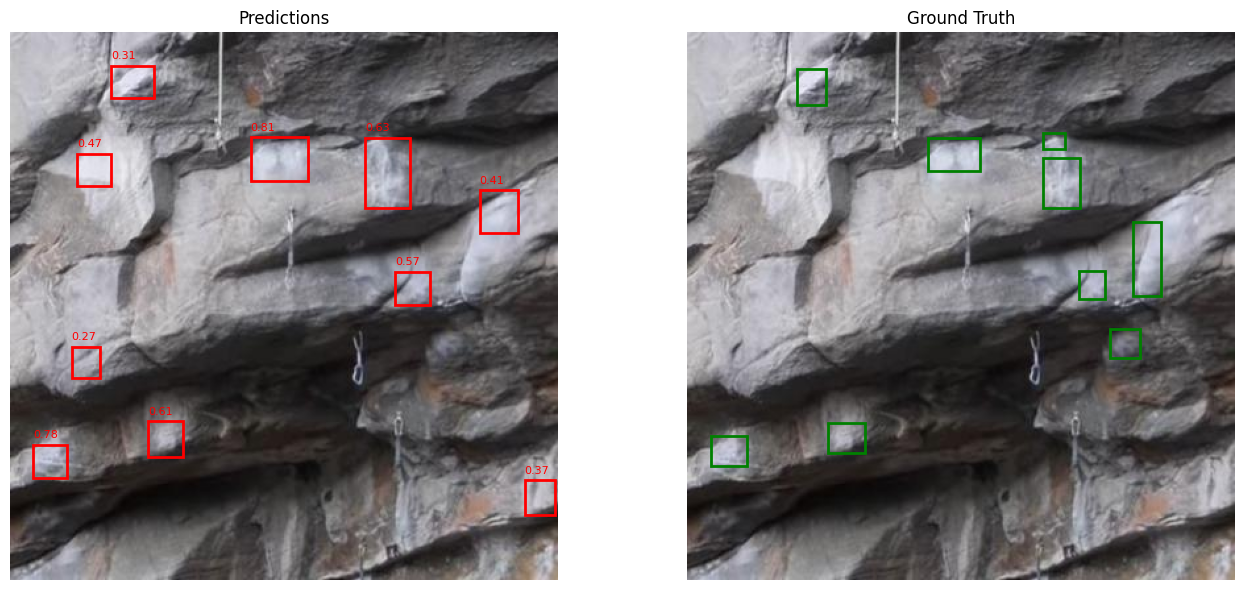

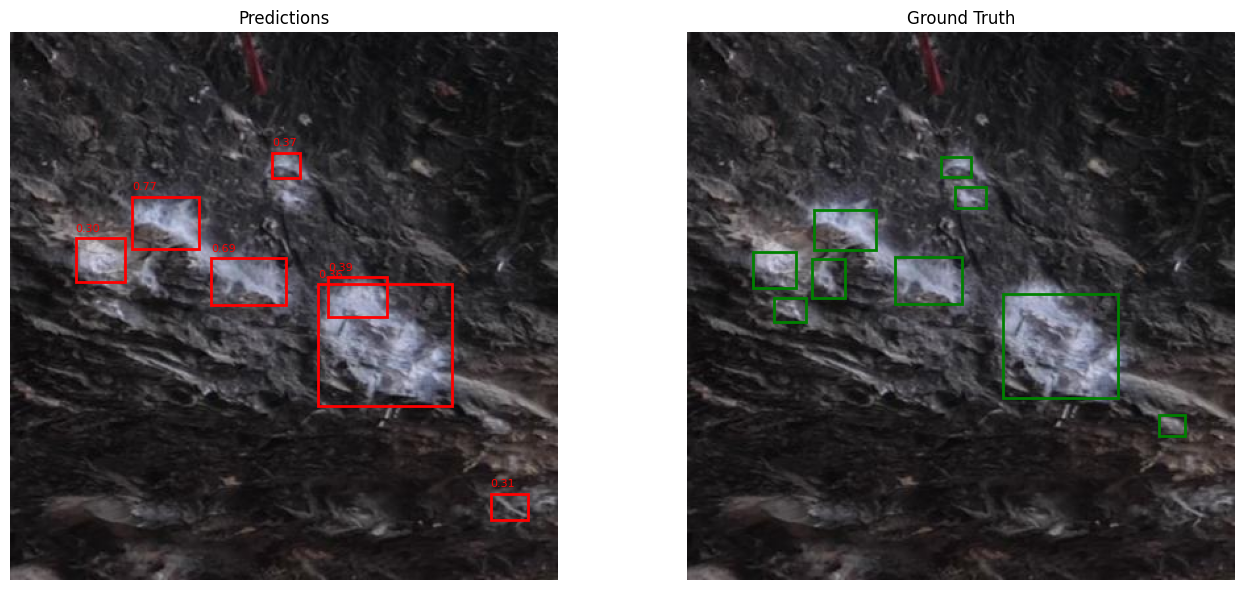

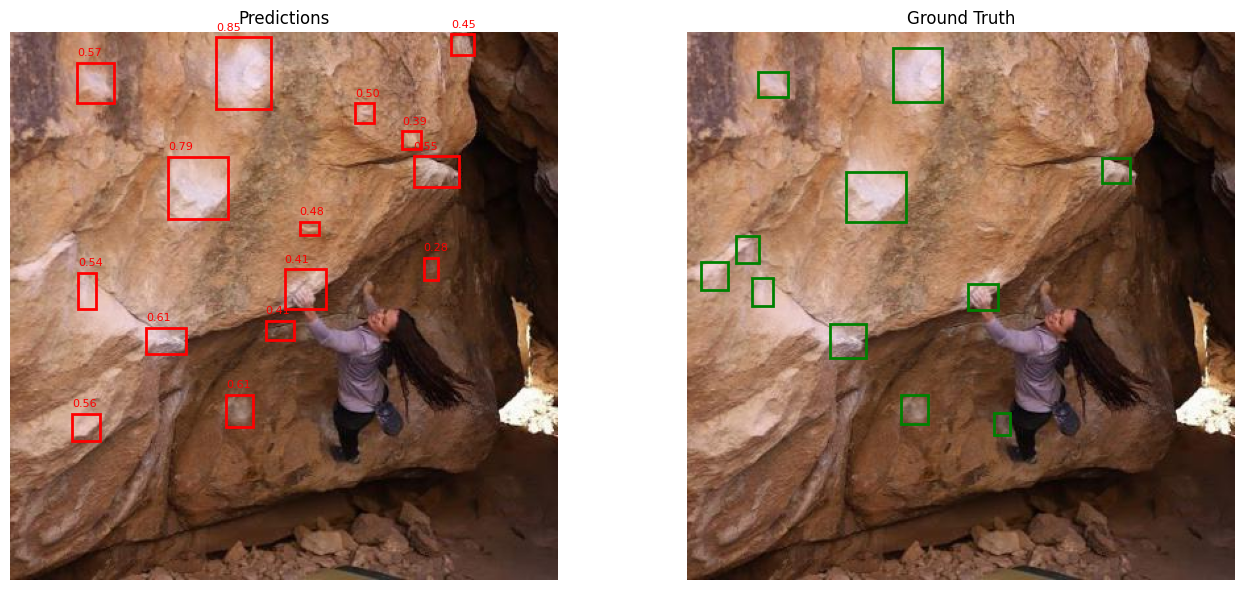

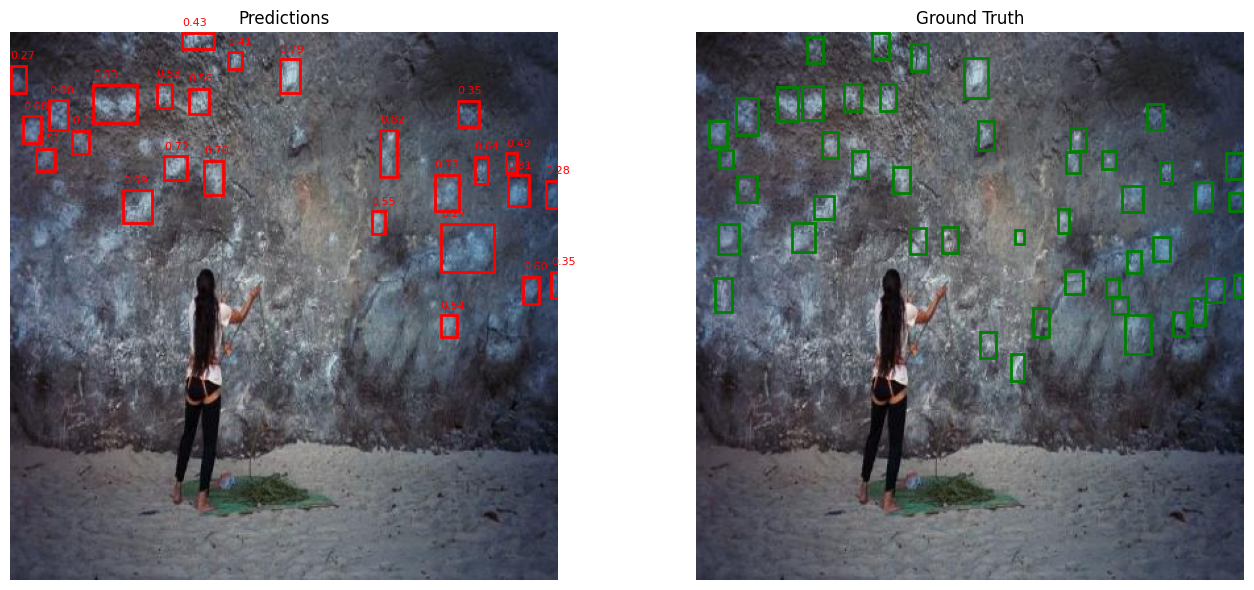

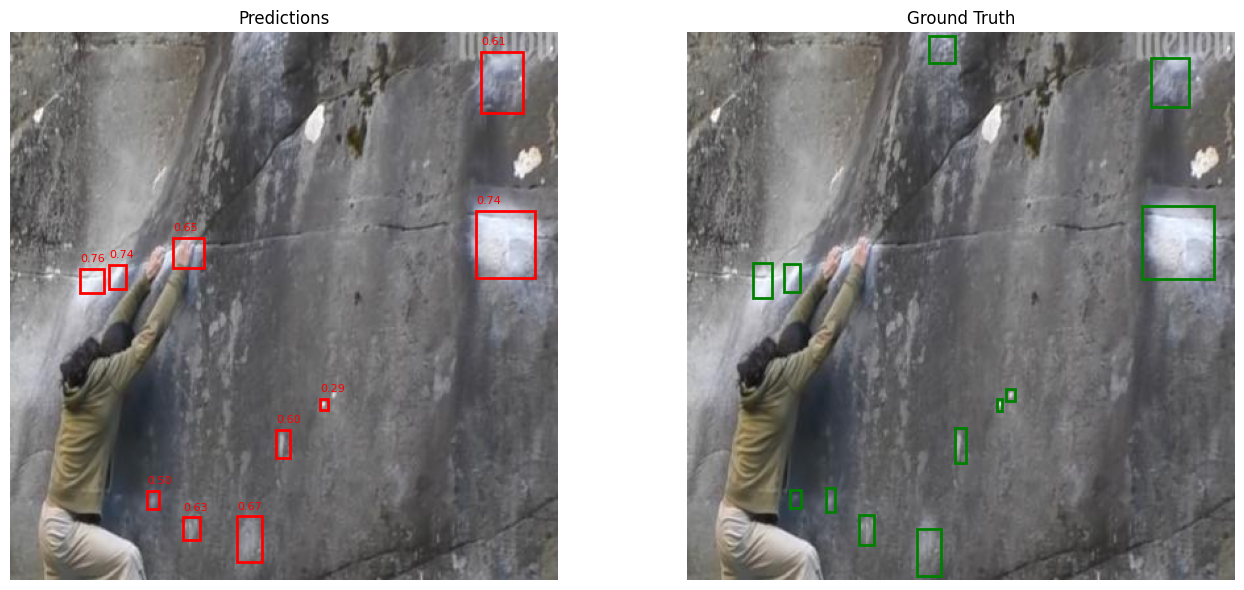

In [4]:
model_path = Path('/content/drive/MyDrive/climbing_holds_model/climbing_holds_final_2/weights/best.pt')
if not model_path.exists():
    model_path = Path('climbing_holds_model.pt')
    if not model_path.exists():
        print("Model file not found.")
        exit()

model = YOLO(model_path)

image_dir = Path('/content/drive/MyDrive/data_(1)/test/images')
label_dir = Path('/content/drive/MyDrive/data_(1)/test/labels')

test_images = list(image_dir.glob('*.jpg'))[:5]

def filter_boxes_by_confidence(results, iou_threshold=0.2):
    filtered_results = []
    for result in results:
        boxes = result.boxes.xyxy.cpu()
        confs = result.boxes.conf.cpu()
        keep = list(range(len(boxes)))
        for i in range(len(boxes)):
            for j in range(i + 1, len(boxes)):
                if i in keep and j in keep:
                    iou = box_iou(boxes[i].unsqueeze(0), boxes[j].unsqueeze(0)).item()
                    if iou >= iou_threshold:
                        if confs[i] >= confs[j]:
                            keep.remove(j)
                        else:
                            keep.remove(i)
        r = result.new()
        r.boxes = result.boxes[keep]
        filtered_results.append(r)
    return filtered_results

results = model(test_images)
filtered_results = filter_boxes_by_confidence(results)

def load_labels(label_path, img_shape):
    h, w = img_shape
    boxes = []
    if label_path.exists():
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    _, x, y, bw, bh = map(float, parts)
                    xmin = (x - bw / 2) * w
                    xmax = (x + bw / 2) * w
                    ymin = (y - bh / 2) * h
                    ymax = (y + bh / 2) * h
                    boxes.append([xmin, ymin, xmax, ymax])
    return boxes

for i, img_path in enumerate(test_images):
    img = plt.imread(img_path)
    h, w = img.shape[:2]
    label_path = label_dir / (img_path.stem + '.txt')
    gt_boxes = load_labels(label_path, (h, w))
    pred_boxes = filtered_results[i].boxes.xyxy.cpu().numpy()
    pred_confs = filtered_results[i].boxes.conf.cpu().numpy()

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].imshow(img)
    axes[0].set_title("Predictions")
    for box, conf in zip(pred_boxes, pred_confs):
        xmin, ymin, xmax, ymax = box
        axes[0].add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                        edgecolor='red', facecolor='none', linewidth=2))
        axes[0].text(xmin, ymin - 5, f"{conf:.2f}", color='red', fontsize=8)

    axes[1].imshow(img)
    axes[1].set_title("Ground Truth")
    for box in gt_boxes:
        xmin, ymin, xmax, ymax = box
        axes[1].add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                        edgecolor='green', facecolor='none', linewidth=2))

    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [31]:
# IoU computation
def compute_iou(box1, box2):
    """Calcule l'IoU entre deux boxes [x1, y1, x2, y2]."""
    x1, y1 = max(box1[0], box2[0]), max(box1[1], box2[1])
    x2, y2 = min(box1[2], box2[2]), min(box1[3], box2[3])
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)

    box1_area = (box1[2]-box1[0]) * (box1[3]-box1[1])
    box2_area = (box2[2]-box2[0]) * (box2[3]-box2[1])

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area else 0

# Convert YOLO (cx, cy, w, h) format to (x1, y1, x2, y2)
def yolo_to_xyxy(yolo_box, img_w, img_h):
    cx, cy, w, h = yolo_box
    x1 = (cx - w / 2) * img_w
    y1 = (cy - h / 2) * img_h
    x2 = (cx + w / 2) * img_w
    y2 = (cy + h / 2) * img_h
    return [x1, y1, x2, y2]

def load_gt_boxes(label_path, img_w, img_h):
    if not os.path.exists(label_path):
        return []
    boxes = []
    with open(label_path, 'r') as f:
        for line in f.readlines():
            cls, cx, cy, w, h = map(float, line.strip().split())
            box = yolo_to_xyxy((cx, cy, w, h), img_w, img_h)
            boxes.append((int(cls), box))
    return boxes

def evaluate_iou(model, images_dir, labels_dir, iou_threshold=0.5):
    images = list(Path(images_dir).glob('*.jpg')) + list(Path(images_dir).glob('*.png'))
    matched = 0
    total_gt = 0

    for image_path in images:
        stem = image_path.stem
        label_path = Path(labels_dir) / f"{stem}.txt"

        img = cv2.imread(str(image_path))
        img_h, img_w = img.shape[:2]

        gt_boxes = load_gt_boxes(label_path, img_w, img_h)
        total_gt += len(gt_boxes)

        result = model(image_path)[0]
        pred_boxes = [(int(box.cls), box.xyxy[0].cpu().numpy()) for box in result.boxes]

        used_gt = set()
        for cls_pred, pred_box in pred_boxes:
            for i, (cls_gt, gt_box) in enumerate(gt_boxes):
                if i in used_gt:
                    continue
                if cls_pred == cls_gt and compute_iou(pred_box, gt_box) >= iou_threshold:
                    matched += 1
                    used_gt.add(i)
                    break

    accuracy = matched / total_gt if total_gt > 0 else 0
    return accuracy

# Chemins
model_path = Path('/content/drive/MyDrive/climbing_holds_model/climbing_holds_final_2/weights/best.pt')
model = YOLO(model_path)

train_acc = evaluate_iou(model,
    '/content/drive/MyDrive/data_(1)/train/images',
    '/content/drive/MyDrive/data_(1)/train/labels')

test_acc = evaluate_iou(model,
    '/content/drive/MyDrive/data_(1)/test/images',
    '/content/drive/MyDrive/data_(1)/test/labels')

print(f"Accuracy (IoU ≥ 0.5) sur TEST : {test_acc:.2%}")


image 1/1 /content/drive/MyDrive/data_(1)/train/images/MATT-PINCUS-1_jpg.rf.e363c23e004fd7d9921d5b4f2ff13b45.jpg: 640x640 15 climbing_holds, 221.2ms
Speed: 6.3ms preprocess, 221.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/data_(1)/train/images/RRG-Muir-Valley-Jesus-Wept_1024x1024_jpg.rf.6b59c492ae66e99a87a0716f899c4c70.jpg: 640x640 21 climbing_holds, 194.2ms
Speed: 3.7ms preprocess, 194.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/data_(1)/train/images/img3_JPG.rf.94d3103c44d9b01fc658b3a520749abd.jpg: 640x640 16 climbing_holds, 193.3ms
Speed: 3.6ms preprocess, 193.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/data_(1)/train/images/dirk_1004149982_ZUxnc-L_jpg.rf.4c087e0c4a17a249b65d53f153834255.jpg: 640x640 39 climbing_holds, 194.8ms
Speed: 3.6ms preprocess, 194.8ms inference, 1.4ms postprocess per image at shape (

In [30]:
# IoU computation
def compute_iou(box1, box2):
    """Calcule l'IoU entre deux boxes [x1, y1, x2, y2]."""
    x1, y1 = max(box1[0], box2[0]), max(box1[1], box2[1])
    x2, y2 = min(box1[2], box2[2]), min(box1[3], box2[3])
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)

    box1_area = (box1[2]-box1[0]) * (box1[3]-box1[1])
    box2_area = (box2[2]-box2[0]) * (box2[3]-box2[1])

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area else 0

# Convert YOLO (cx, cy, w, h) format to (x1, y1, x2, y2)
def yolo_to_xyxy(yolo_box, img_w, img_h):
    cx, cy, w, h = yolo_box
    x1 = (cx - w / 2) * img_w
    y1 = (cy - h / 2) * img_h
    x2 = (cx + w / 2) * img_w
    y2 = (cy + h / 2) * img_h
    return [x1, y1, x2, y2]

def load_gt_boxes(label_path, img_w, img_h):
    if not os.path.exists(label_path):
        return []
    boxes = []
    with open(label_path, 'r') as f:
        for line in f.readlines():
            cls, cx, cy, w, h = map(float, line.strip().split())
            box = yolo_to_xyxy((cx, cy, w, h), img_w, img_h)
            boxes.append((int(cls), box))
    return boxes

def evaluate_iou(model, images_dir, labels_dir, iou_threshold=0.5):
    images = list(Path(images_dir).glob('*.jpg')) + list(Path(images_dir).glob('*.png'))
    matched = 0
    total_gt = 0

    for image_path in images:
        stem = image_path.stem
        label_path = Path(labels_dir) / f"{stem}.txt"

        img = cv2.imread(str(image_path))
        img_h, img_w = img.shape[:2]

        gt_boxes = load_gt_boxes(label_path, img_w, img_h)
        total_gt += len(gt_boxes)

        result = model(image_path)[0]
        pred_boxes = [(int(box.cls), box.xyxy[0].cpu().numpy()) for box in result.boxes]

        used_gt = set()
        for cls_pred, pred_box in pred_boxes:
            for i, (cls_gt, gt_box) in enumerate(gt_boxes):
                if i in used_gt:
                    continue
                if cls_pred == cls_gt and compute_iou(pred_box, gt_box) >= iou_threshold:
                    matched += 1
                    used_gt.add(i)
                    break

    accuracy = matched / total_gt if total_gt > 0 else 0
    return accuracy

# Chemins
model_path = Path('/content/drive/MyDrive/climbing_holds_model/climbing_holds_cosine_anchor_tuned/weights/PACTEv3.pt')
model = YOLO(model_path)

train_acc = evaluate_iou(model,
    '/content/drive/MyDrive/data_(1)/train/images',
    '/content/drive/MyDrive/data_(1)/train/labels')

test_acc = evaluate_iou(model,
    '/content/drive/MyDrive/data_(1)/test/images',
    '/content/drive/MyDrive/data_(1)/test/labels')

print(f"Accuracy (IoU ≥ 0.5) sur TEST : {test_acc:.2%}")


image 1/1 /content/drive/MyDrive/data_(1)/train/images/MATT-PINCUS-1_jpg.rf.e363c23e004fd7d9921d5b4f2ff13b45.jpg: 640x640 15 climbing_holds, 424.7ms
Speed: 8.1ms preprocess, 424.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/data_(1)/train/images/RRG-Muir-Valley-Jesus-Wept_1024x1024_jpg.rf.6b59c492ae66e99a87a0716f899c4c70.jpg: 640x640 18 climbing_holds, 333.0ms
Speed: 8.9ms preprocess, 333.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/data_(1)/train/images/img3_JPG.rf.94d3103c44d9b01fc658b3a520749abd.jpg: 640x640 16 climbing_holds, 373.6ms
Speed: 6.3ms preprocess, 373.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/data_(1)/train/images/dirk_1004149982_ZUxnc-L_jpg.rf.4c087e0c4a17a249b65d53f153834255.jpg: 640x640 40 climbing_holds, 309.1ms
Speed: 5.4ms preprocess, 309.1ms inference, 1.8ms postprocess per image at shape (